# plotting GAIA stars on one LCOGT image

La Cumbres FITS header explanation:

https://lco.global/documentation/data/fits-headers/

What the BANZAI pipeline does:

https://lco.global/documentation/data/BANZAIpipeline/ 

Object identification and extraction is through the SEP pipeline:

CAT: the catalog of sources detected by SEP in a FITS binary table. The catalog lists the pixel positions (X, Y), semi-major and semi-minor axes (A, B), positions angles (THETA), fluxes and errors (FLUX, FLUXERR) of each source.

AND the BANZAI object identification table:

https://sep.readthedocs.io/en/v1.1.x/tutorial.html


In [1]:
from astropy.coordinates import Angle

from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
%matplotlib notebook
from matplotlib import cm
from astropy.io import ascii

In [2]:
r_mag = ascii.read('gaia_stars.ecsv')

In [3]:
r_mag

<Table length=108>
    solution_id             designation          ...          dist         
                                                 ...                       
       int64                   object            ...        float64        
------------------- ---------------------------- ... ----------------------
1635721458409799680 Gaia DR2 5539970601632026752 ... 0.00040976969754023167
1635721458409799680 Gaia DR2 5539970597334497024 ...  0.0014120313739027625
1635721458409799680 Gaia DR2 5539970635991769856 ...   0.014235666519282118
1635721458409799680 Gaia DR2 5539970356813626240 ...   0.018351021424754105
1635721458409799680 Gaia DR2 5539972113460503552 ...    0.03110563753362007
1635721458409799680 Gaia DR2 5539982421382028672 ...   0.031437088576025174
1635721458409799680 Gaia DR2 5539971838582596992 ...   0.033575274162921456
1635721458409799680 Gaia DR2 5539983898850772352 ...     0.0338697711798177
1635721458409799680 Gaia DR2 5539983933210506496 ...   0.034068700036471465
                ...                          ... ...                    ...
1635721458409799680 Gaia DR2 5539969948797043072 ...    0.10568002568070231
1635721458409799680 Gaia DR2 5539975893031782656 ...    0.10619082173739855
1635721458409799680 Gaia DR2 5539983005497613312 ...    0.10640277990155296
1635721458409799680 Gaia DR2 5539971701143607168 ...    0.10833805468351226
1635721458409799680 Gaia DR2 5539972525778328320 ...      0.108356373239264
1635721458409799680 Gaia DR2 5539985101441609856 ...    0.10856224811711362
1635721458409799680 Gaia DR2 5539971284527745664 ...    0.10858390977060044
1635721458409799680 Gaia DR2 5539969880077566080 ...    0.10967774852470863
1635721458409799680 Gaia DR2 5539975824312307840 ...    0.11027714249121635
1635721458409799680 Gaia DR2 5539982902418403328 ...    0.11028431089345271

<IPython.core.display.Javascript object>


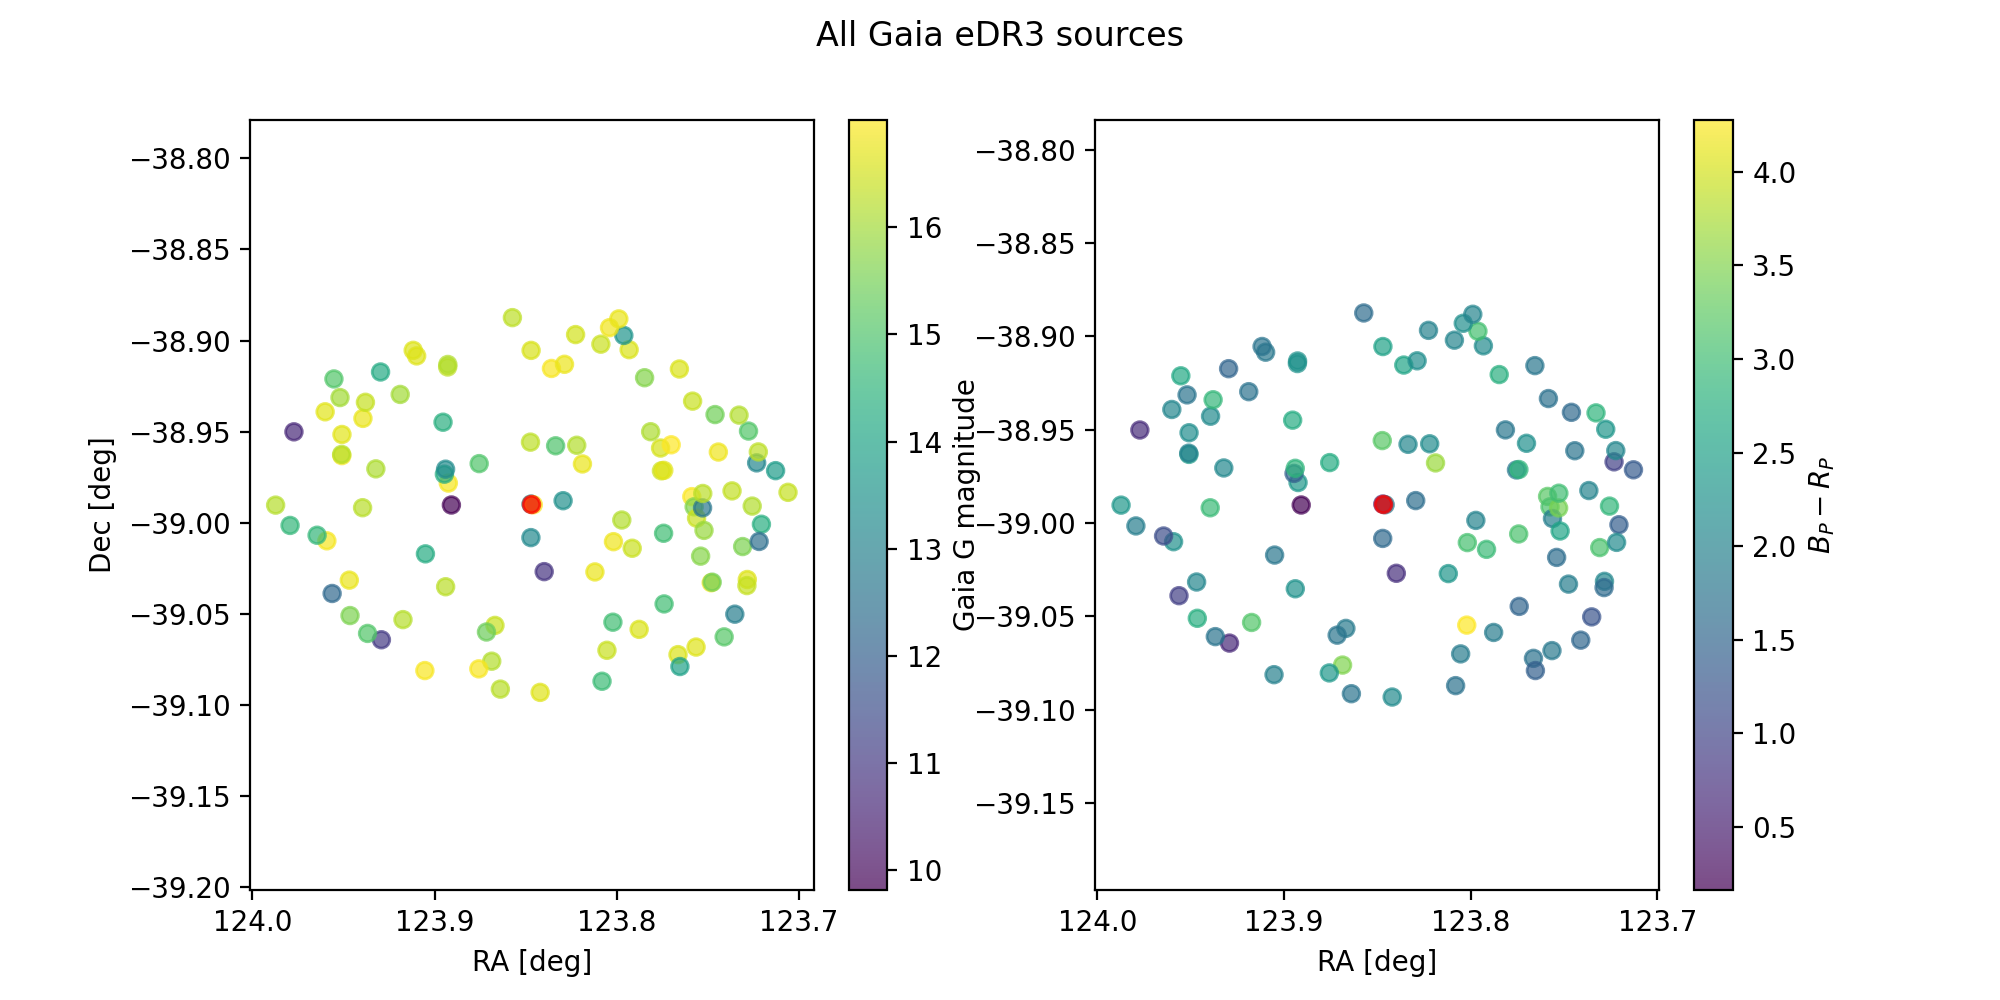

In [4]:
fi, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))

sc = ax1.scatter(r_mag['ra'],r_mag['dec'],c=r_mag['phot_g_mean_mag'],alpha=0.7,cmap=plt.get_cmap('viridis'))
ax1.scatter(r_mag['ra'][0],r_mag['dec'][0],c='red',alpha=0.7)

ax1.axis('equal')
ax1.invert_xaxis()

ax1.set_xlabel('RA [deg]')
ax1.set_ylabel('Dec [deg]')

cbar = plt.colorbar(sc,ax=ax1)
cbar.set_label('Gaia G magnitude')


sc2 = ax2.scatter(r_mag['ra'],r_mag['dec'],c=r_mag['bp_rp'],alpha=0.7,cmap=plt.get_cmap('viridis'))
ax2.scatter(r_mag['ra'][0],r_mag['dec'][0],c='red',alpha=0.7)

ax2.axis('equal')
ax2.invert_xaxis()

ax2.set_xlabel('RA [deg]')
#ax2.set_ylabel('Dec [deg]')
fi.suptitle('All Gaia eDR3 sources')

cbar = plt.colorbar(sc2,ax=ax2)
cbar.set_label('$B_P - R_P$')

In [13]:
from astropy.io import fits
from astropy import wcs

imname = 'data/lco/coj1m003-fa19-20211026-0191-e91.fits.fz'
print('opening {}'.format(imname))
hdu1 = fits.open(imname)

imh = hdu1['SCI'].header
image = hdu1['SCI'].data

epoch = imh['MJD-OBS']
print('{:.5f} MJD'.format(epoch))

# read in photometric data FITS table
objects = hdu1['CAT'].data


opening data/lco/coj1m003-fa19-20211026-0191-e91.fits.fz
59513.66947 MJD


In [14]:
len(objects)

2388

In [15]:
# Parse the WCS keywords in the primary HDU
w = wcs.WCS(hdu1['SCI'].header)


Set OBSGEO-B to   -31.273025 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [16]:
objects['y']

array([ 839.27913876, 1221.2666991 , 3587.7501477 , ...,   36.39191701,
         33.24268867,   27.40888073])

<IPython.core.display.Javascript object>


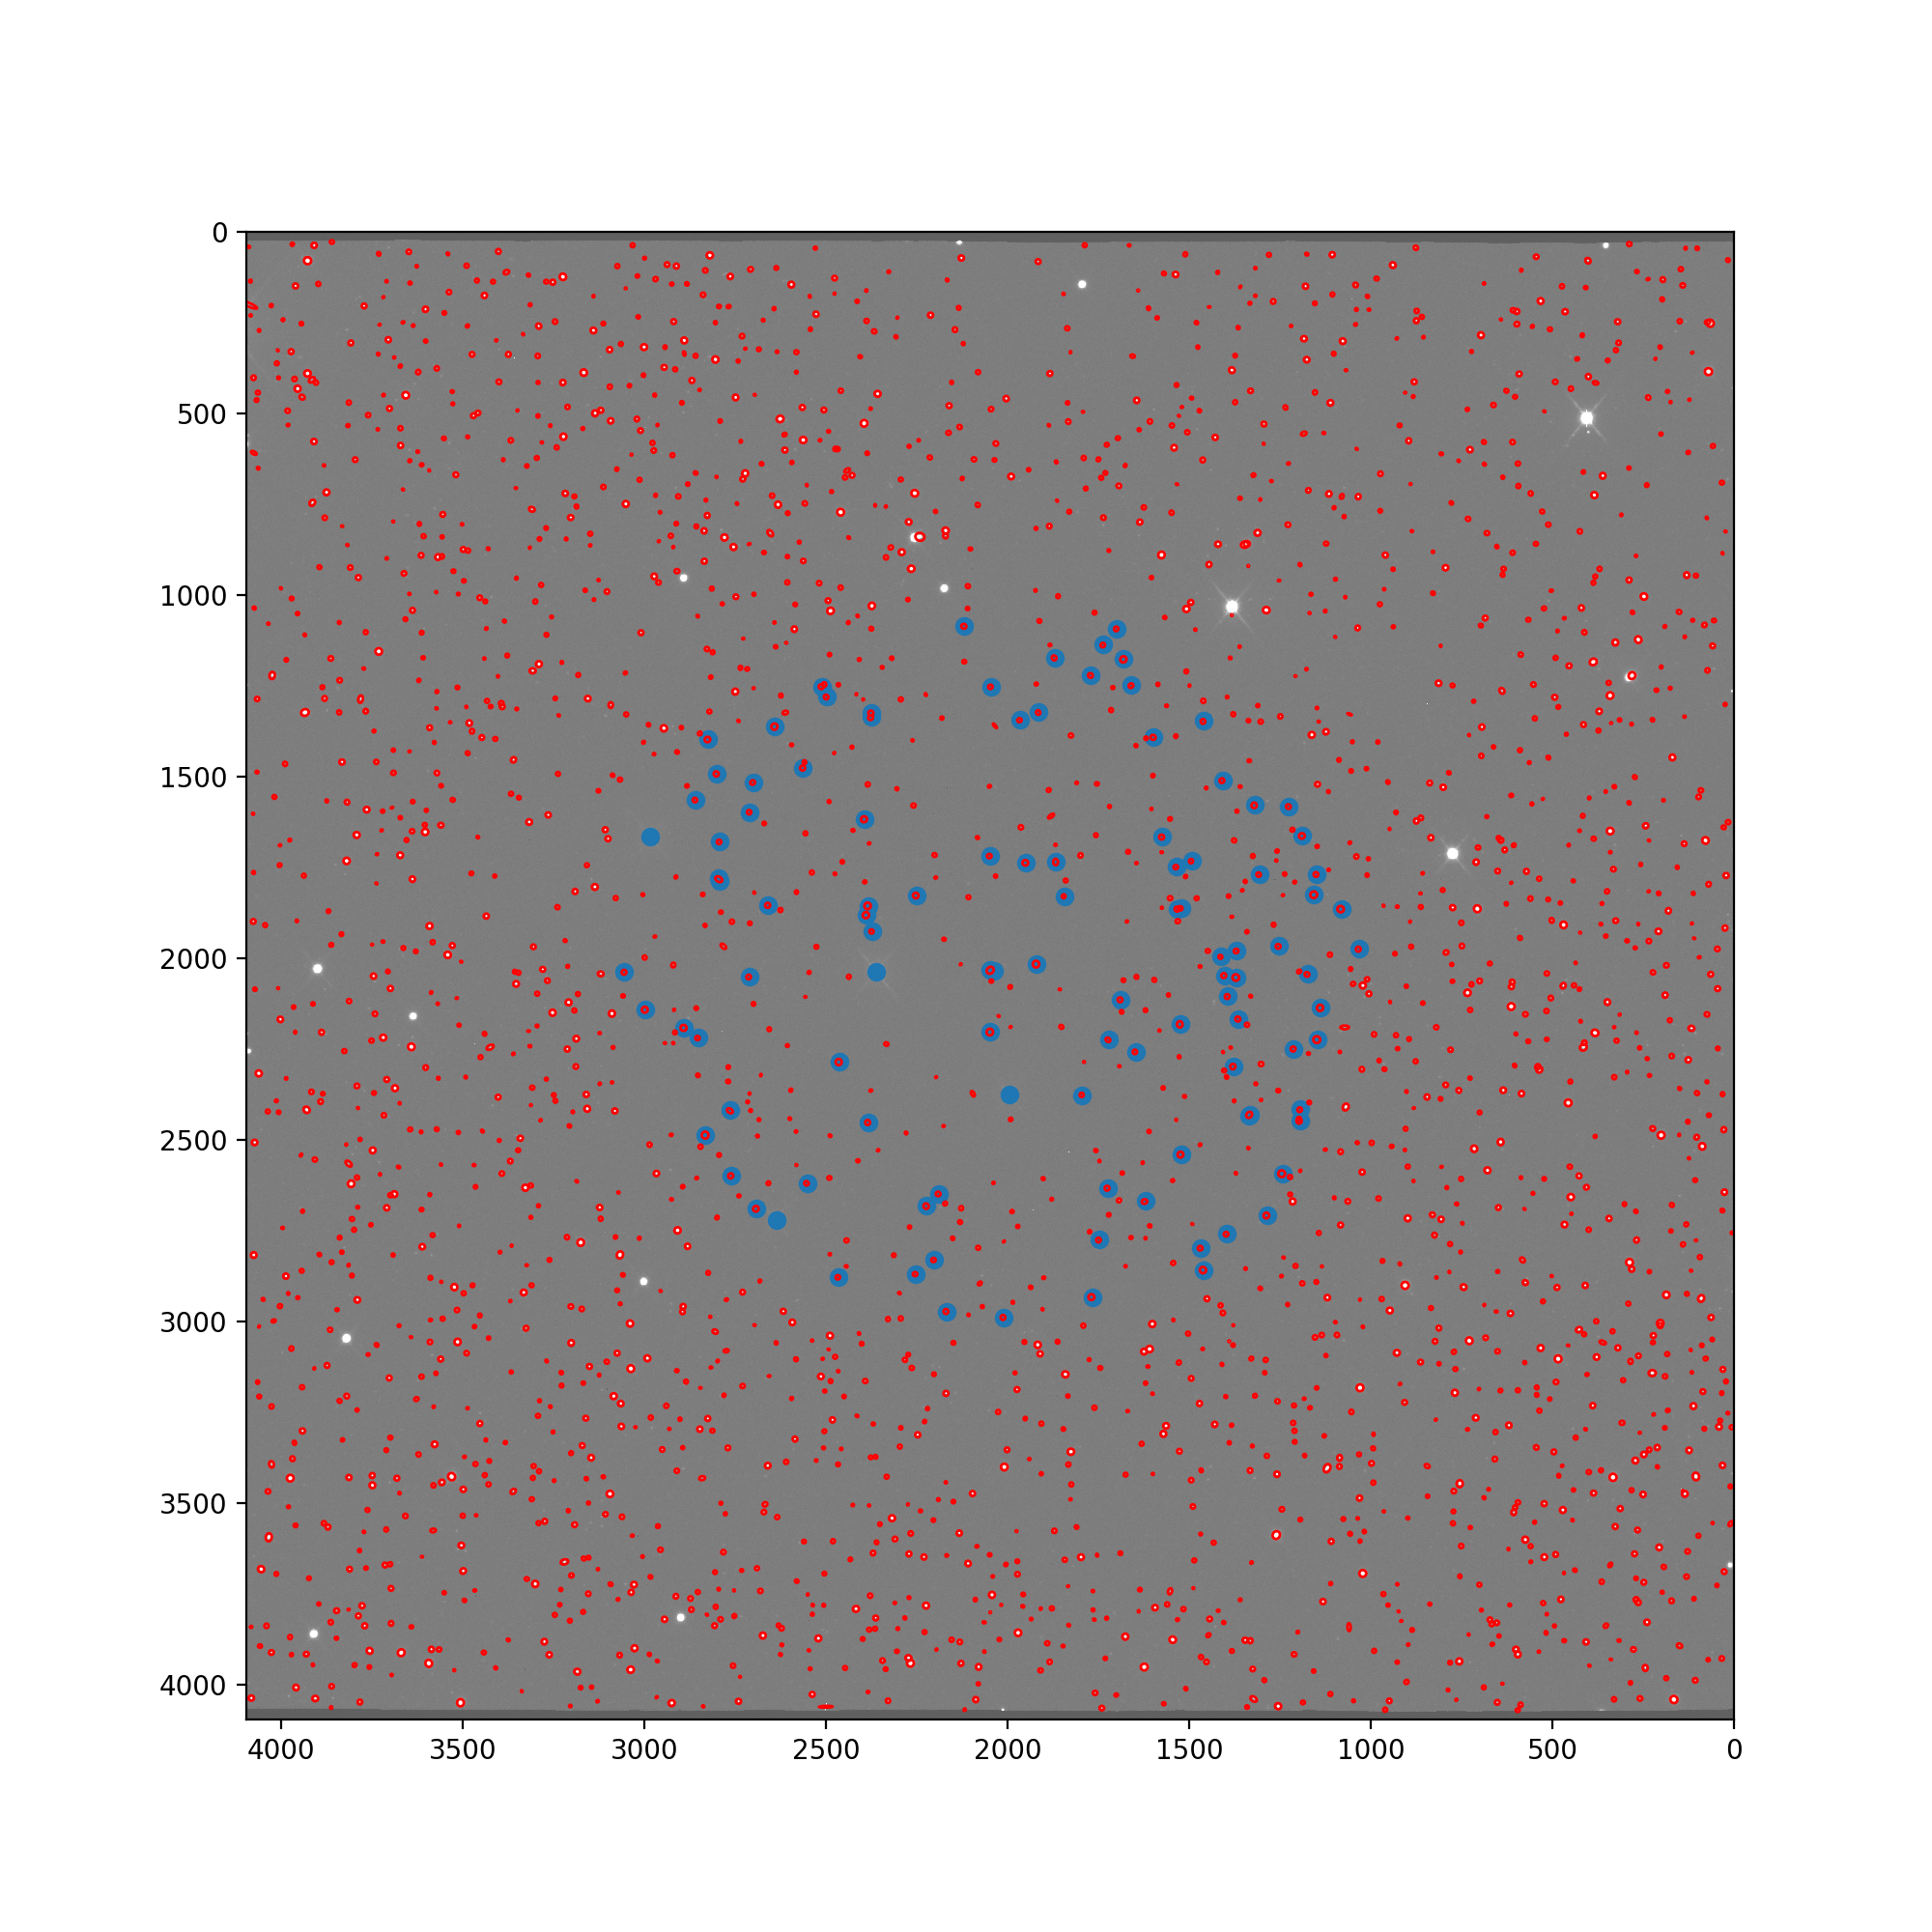

In [17]:
from matplotlib.patches import Ellipse


data_sub = image
fig, ax = plt.subplots(figsize=(10,10))
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

ax.invert_yaxis()
ax.invert_xaxis()

# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)
    
    
# convert the gaia RA dec to x,y positions on thr image
star_crd = w.wcs_world2pix(np.array([r_mag['ra'],r_mag['dec']]).transpose(), 0) # star
ax.scatter(star_crd[:,0],star_crd[:,1])

In [18]:
objects.dtype.names


('x',
 'y',
 'xwin',
 'ywin',
 'xpeak',
 'ypeak',
 'flux',
 'fluxerr',
 'peak',
 'fluxaper1',
 'fluxerr1',
 'fluxaper2',
 'fluxerr2',
 'fluxaper3',
 'fluxerr3',
 'fluxaper4',
 'fluxerr4',
 'fluxaper5',
 'fluxerr5',
 'fluxaper6',
 'fluxerr6',
 'background',
 'fwhm',
 'a',
 'b',
 'theta',
 'kronrad',
 'ellipticity',
 'fluxrad25',
 'fluxrad50',
 'fluxrad75',
 'x2',
 'y2',
 'xy',
 'flag',
 'ra',
 'dec',
 'mag',
 'magerr')

For each star in the gaia catalogue, see if you can find the same star in image

The gaia catalogue table is fixed, with the row 0 star the target star.

Output table contains the 

(2388, 108)


<IPython.core.display.Javascript object>


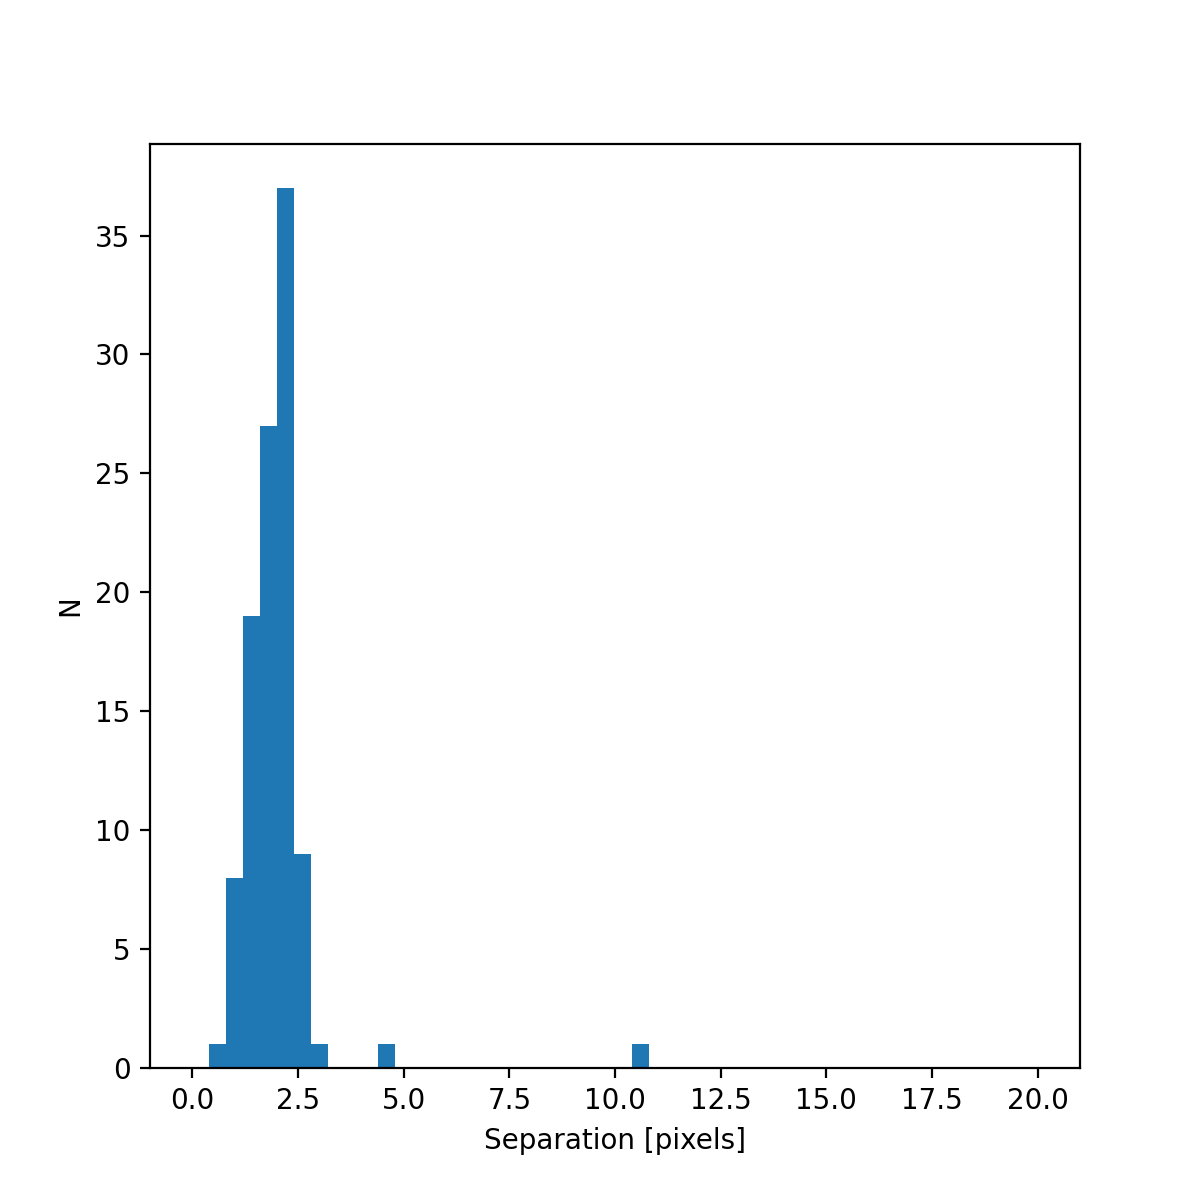

108
101


In [19]:
def find_close(star_gaia, b, tol=3.):
    '''star_gaia  - x,y positions of gaia stars on the detector
     b - the Table object that has the extracted photometry from the BANZAI reduction of LCOGT
    tol - tolerance of star match in pixels
    returns an array of length (star_gaia) which contain the inxex to the matched star in `b`, 
    with -9999 as no match within the tolerace `tol`.
    NOTE: not able to use np.nan because indices are int and nan is np.float only.
    '''
    #ax.scatter(star_crd[:,0],star_crd[:,1])
    xg = star_gaia[:,0]
    yg = star_gaia[:,1]
    
    xban = b['x']
    yban = b['y']
    
    # calculate distance between all gaia stars and all detected objects
    dx = xg - xban[:,np.newaxis]
    dy = yg - yban[:,np.newaxis]
    dr2 = np.sqrt(dx*dx + dy*dy)
    
    print(dr2.shape)
    # find the minimum separation between the gaia object and all the BANZAI objects 
    r_sep = np.amin(dr2,axis=0)
    
    # get the indices for the minimum r_sep
    r_argsep = np.argmin(dr2,axis=0)
    
    fi, ax = plt.subplots(1,1,figsize=(6,6))
    ax.hist(r_sep,range=(0,20),bins=50)
    ax.set_xlabel('Separation [pixels]')
    ax.set_ylabel('N')
    
    r_argsep[(r_sep>tol)] = -9999

    return r_argsep
    
rr = find_close(star_crd, objects)

print(rr.size)
print(np.sum(rr>0))


<IPython.core.display.Javascript object>


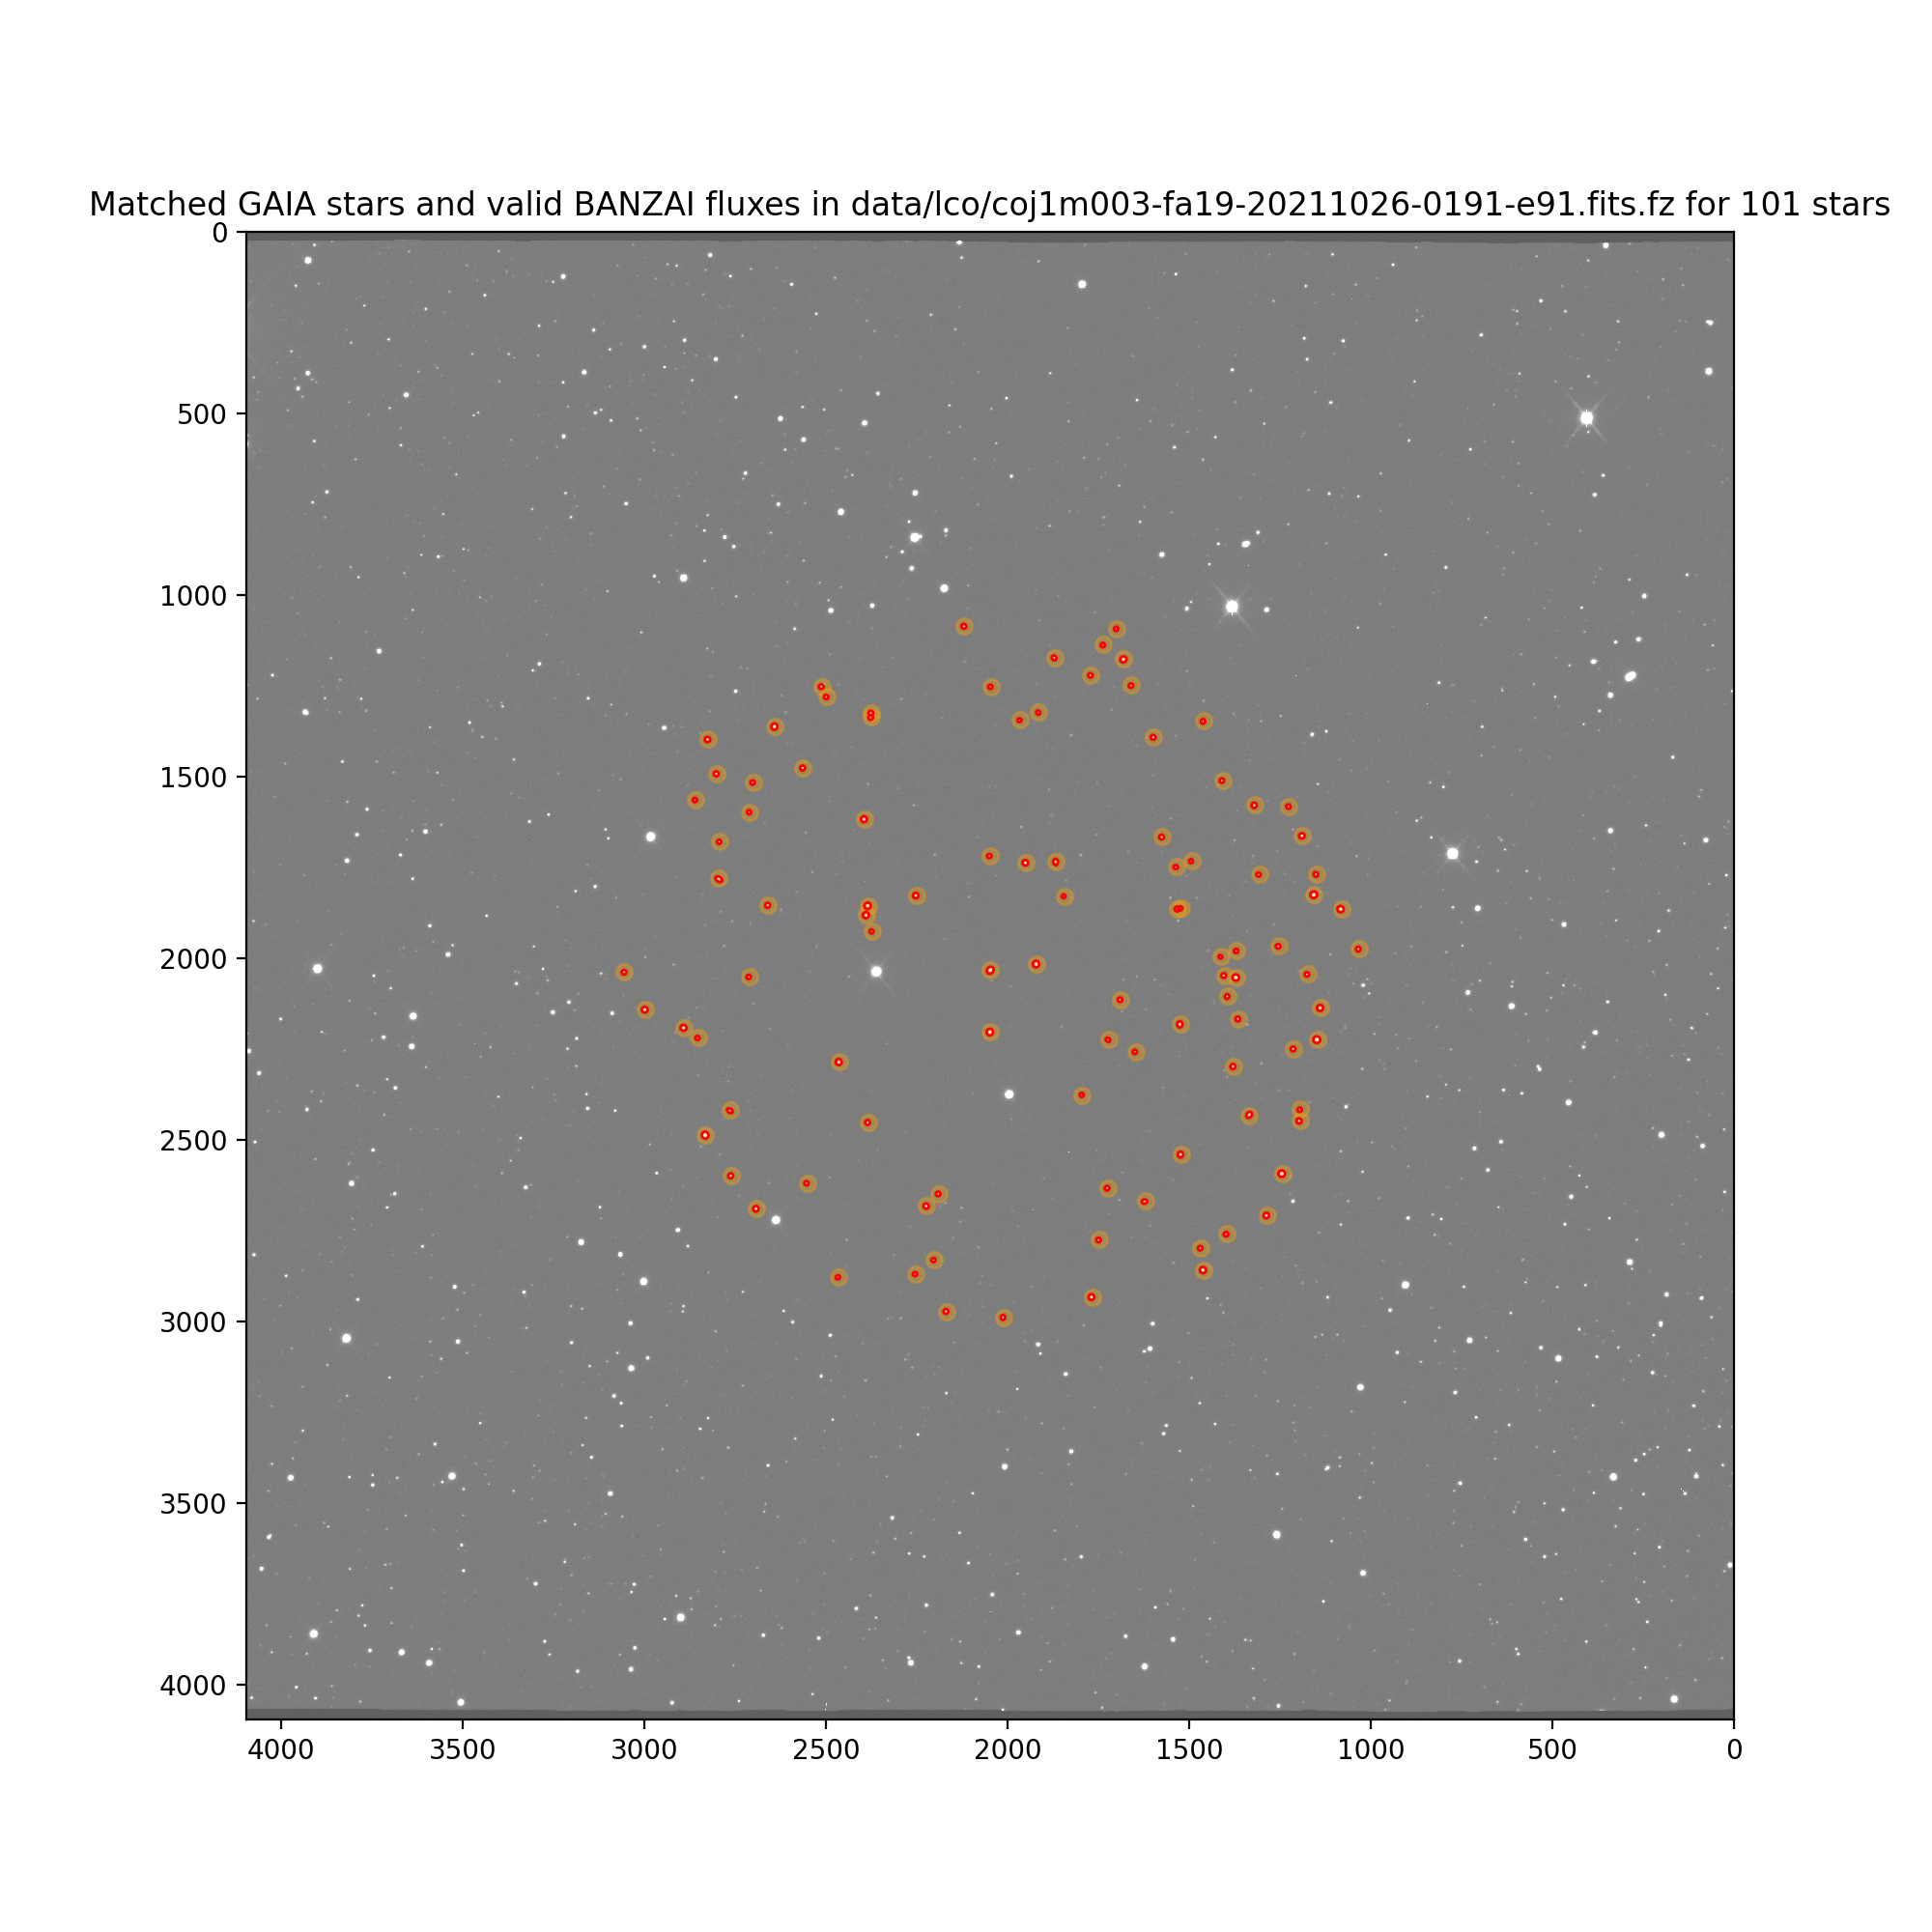

Text(0.5, 1.0, 'Matched GAIA stars and valid BANZAI fluxes in data/lco/coj1m003-fa19-20211026-0191-e91.fits.fz for 101 stars')

In [20]:

data_sub = image
fig, ax = plt.subplots(figsize=(10,10))
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

ax.invert_yaxis()
ax.invert_xaxis()

# plot an ellipse for each object
for (gindex, i) in enumerate(rr):
    if i < 0:
        continue
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)
    ax.scatter(star_crd[gindex,0],star_crd[gindex,1],color='orange',alpha=0.3)
    
ax.set_title('Matched GAIA stars and valid BANZAI fluxes in {} for {} stars'.format(imname,np.sum(rr>0)))
    